In [212]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

import sys
sys.path.append('../src/')

idxs = pd.IndexSlice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
taz = gpd.read_file('../data/TAZ/Zonas.shp').drop(columns='ESTADO')

In [214]:
from od import (
    load_od, plot_trips, insert_trip, fix_od_chains, check_od_chains,
    check_overlap, get_purpose_tmat, index_next_trip, index_prev_trip,
    fix_home_loc, build_people_table, build_household_table, build_trips
)

In [215]:
%%time
od_df = load_od('../data/OD_Survey/pimus_final.csv')

trips, legs_wide = build_trips(od_df)
people = build_people_table(od_df, trips)
households = build_household_table(od_df, people)

trips['ntrip'] = np.nan
trips.loc[trips.Motivo=='estudios', 'ntrip'] = trips.loc[trips.Motivo=='estudios'].groupby(['HOGAR', 'HABITANTE']).Motivo.transform('rank', method='first')
trips.loc[trips.Motivo=='trabajo', 'ntrip'] = trips.loc[trips.Motivo=='trabajo'].groupby(['HOGAR', 'HABITANTE']).Motivo.transform('rank', method='first')

88.39450686641698% of households have been ajusted.
0.7790262172284644 of households are missing members above 6 years of age.
CPU times: user 34.3 s, sys: 1.59 s, total: 35.9 s
Wall time: 36.8 s


In [482]:
from od import personas_as_od, viviendas_as_od

personas = personas_as_od(Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Personas19.CSV'))
viviendas = viviendas_as_od(Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Viviendas19.CSV'), personas, households)

In [216]:
households_models = (
    pd.DataFrame(index=households.index)
    .assign(
        HouseholdId=range(len(households)),
        HouseholdZone=households.TAZ.map(zones_map),
        ExpansionFactor=trips.groupby('HOGAR').FACTOR.mean().reindex(households.index).fillna(1),
        NumberOfPersons=households.NUMPERS,
        DwellingType=households.CLAVIVP.map({'SinNumInt': 1, 'ConNumInt': 2}),
        Vehicles=households.NumberOfVehicles.astype(int),  # Auto+Pickup+Moto
        IncomeClass=households.NSE.map({'E': 1, 'D': 2, 'D+': 3, 'C-': 4, 'C': 4, 'C+': 5, 'A/B': 6, np.nan: 7})
    )
)

In [217]:
people_models = (
    pd.DataFrame(index=people.index)
    .assign(
        HouseholdId=households_models.HouseholdId.reindex(people.index, level=0),
        PersonNumber=people.index.get_level_values(1),
        Age=people.Edad,
        Sex=people.SEXO,
        License=(people.Edad >= 18).map({True: 'Y', False: 'N'}),
        TransitPass='N',
        EmploymentStatus=people.CONACT.map(
            {
                'Trabajó': 'F', 
                'No trabaja': 'O', 
                'Se dedica a los quehaceres del hogar': 'O', 
                'Es pensionada(o) o jubilada(o)': 'O'
            }
        ).mask(people.informal==1, 'P'),
        Occupation=people.ACTIVIDADES_C.map(
            {
                'Blanco por pase': 'O',
                'servicios': 'P',
                'industria manufacturera': 'M',
                'comercio': 'S',
                'construcción': 'M',
                'otro': 'G',
                'transporte y comunicaciones': 'G',
                'gobierno': 'G',
                'agricultura y ganadería': 'G',
                'minería': 'G',
            }
        ).fillna('G'),
        FreeParking='O',
        StudentStatus=people.ASISTEN.map({'No': 'O', 'Sí': 'S'}),
        EmploymentZone=people.TAZ_TRAB.replace('Blanco por pase', 0).fillna(0).astype(int).map(zones_map).fillna(0),
        SchoolZone=people.TAZ_ASI.replace('Blanco por pase', 0).fillna(0).astype(int).map(zones_map).fillna(0),
        ExpansionFactor=households_models.ExpansionFactor.reindex(people.index, level=0)
    )
)

In [752]:
purp_dest = trips.Motivo.map(
    {
        'regreso a casa': 'H',
        'trabajo': 'W',
        'estudios': 'S',
        'compras': 'M',
        'acompañar / recoger': 'F',
        'recreación': 'E',
        'otro': 'O',
        'salud': 'O'
    }
)

purp_orig = pd.Series('', index=purp_dest.index)
purp_orig.loc[idxs[:, :, 1]] = trips.loc[idxs[:, :, 1], 'Origen'].map({'Hogar': 'H', 'Otro': 'O'})
pidx = index_prev_trip(purp_dest.loc[idxs[:, :, 2:]].index)
purp_orig.loc[idxs[:, :, 2:]] = purp_dest.loc[pidx].values

purp_dest = purp_dest.mask((trips.ntrip > 1) & (purp_dest == 'W'), 'R')
purp_dest = purp_dest.mask((trips.ntrip > 1) & (purp_dest == 'S'), 'C')

trips_models = (
    pd.DataFrame(index=trips.index)
    .assign(
        HouseholdId=households_models.HouseholdId.reindex(trips.index, level=0),
        PersonNumber=people_models.PersonNumber.reindex(trips.index),
        TripNumber=trips.index.get_level_values(2),
        StartTime=(trips.fecha_inicio.dt.hour*100 + trips.fecha_inicio.dt.minute).astype(int),
        Mode=trips['Modo Agrupado'].map({
            'a pie (caminando)': 'W',
            'automóvil (conductor)': 'D',
            'tpub': 'B',
            'automóvil (pasajero)': 'P',
            'transporte de personal': 'O',
            'taxi': 'T',
            'transporte escolar': 'S',
            'uber, cabify , didi o similar': 'U',
            'modos combinados con tpub': 'B',
            'bicicleta': 'C',
            'motocicleta': 'M',
            'otro': 'O',
            'modos combinados sin tpub': '9',
            'motocicleta (conductor)': 'M',
            'transporte público': 'B',
            'patineta': 'O'
        }),
        PuposeOrigin=purp_orig,
        ZoneOrigin=trips.ZonaOri.astype(int).map(zones_map),
        PurposeDestination=purp_dest,
        ZoneDestination=trips.ZonaDest.astype(int).map(zones_map)
    )
)

In [779]:
import fiona
layers = fiona.listlayers('taz_census.gpkg')

taz_census = []
for layer in layers:
    taz_census.append(gpd.read_file('taz_census.gpkg', layer=layer))
taz_census = pd.concat(taz_census)

In [753]:
households_models.to_csv('../output/od_households.csv', index=False)
people_models.to_csv('../output/od_people.csv', index=False)
trips_models.to_csv('../output/od_trips.csv', index=False)

In [179]:
import json

with open('../data/TAZ/zones_mapping.json', 'r') as f:
    zones_map = json.load(f)

zones_map = {int(k): v for k,v in zones_map.items()}

In [628]:
taz['ZONA_2'] = taz.ZONA.map(zones_map)
taz['MACROZONA'] = taz.MACROZONA.fillna(999)
taz['MUNICIPIO'] = taz.MUNICIPIO.fillna('External')

In [661]:
taz_dist = pd.read_csv('../data/TAZ/zonedistances_final.csv', index_col=0)
taz_dist.columns = taz_dist.columns.astype(int)

In [210]:
def get_mean_dist(people_df, households_df, taz_dist, col='SchoolZone'):
    df = (
        people_df.loc[people_df[col] > 0, col]
        .astype(int)
        .to_frame()
    )
    df = df.assign(
        HouseholdZone=households_df.loc[df.index.droplevel(1), 'HouseholdZone'].values
    )
    idx = pd.MultiIndex.from_arrays(
        [
            df.HouseholdZone.values, 
            df[col].values, 
        ]
    )
    df = df.assign(dist=taz_dist.stack().loc[idx].values)
    return df.groupby('HOGAR').dist.mean()  

In [787]:
# Add columns for vehicle model

# Macrozone and Municipality
households_models_2 = households_models.reset_index().merge(
    taz[['ZONA_2', 'MACROZONA', 'MUNICIPIO']],
    left_on='HouseholdZone',
    right_on='ZONA_2',
    how='left'
).drop(columns='ZONA_2').set_index('HOGAR').sort_index()

# number for formal and informal workers
households_models_2 = households_models_2.assign(
    NumberOfFormalWorkers=(
        people_models.query("EmploymentStatus == 'F'")
        .groupby('HOGAR').size()
        .reindex(households_models.index).fillna(0).astype(int)
    ),
    NumberOfInformalWorkers=(
        people_models.query("EmploymentStatus == 'P'")
        .groupby('HOGAR').size()
        .reindex(households_models.index).fillna(0).astype(int)
    ),
    NumberOfLicenses = (
        people_models.query("License == 'Y'")
        .groupby('HOGAR').size()
        .reindex(households_models.index).fillna(0).astype(int)
    ),
    DistanceEmployment=get_mean_dist(people_models, households_models, taz_dist, 'EmploymentZone').reindex(households_models.index).fillna(-1),
    DistanceSchool=get_mean_dist(people_models, households_models, taz_dist, 'SchoolZone').reindex(households_models.index).fillna(-1),
    #ZoneDensity=0.0,
)
# zone population density

In [ ]:
households_models_2.to_csv()

In [791]:
households_models_2.merge(
    taz_census[['ZONA', 'AREA', 'POBTOT']].copy().assign(
        HouseholdZone=taz_census.ZONA.map(zones_map),
        ZoneDensity=taz_census.POBTOT/taz_census.AREA
    ),
    on='HouseholdZone',
    how='left'
).query("ZoneDensity.isna()")

,HouseholdId,HouseholdZone,ExpansionFactor,NumberOfPersons,DwellingType,Vehicles,IncomeClass,MACROZONA,MUNICIPIO,NumberOfFormalWorkers,NumberOfInformalWorkers,NumberOfLicenses,DistanceEmployment,DistanceSchool,ZONA,AREA,POBTOT,ZoneDensity
13817,13817,701,184.110175,2,1,1,2,72.0,Apodaca,0,0,2,-1.000,-1.000000,805,0.375505,NaN,NaN
13818,13818,701,155.562504,2,1,0,2,72.0,Apodaca,1,0,2,1.720,-1.000000,805,0.375505,NaN,NaN
13819,13819,701,178.709695,4,1,1,3,72.0,Apodaca,2,0,3,-1.000,0.400000,805,0.375505,NaN,NaN
13822,13822,701,128.380884,4,1,0,2,72.0,Apodaca,1,0,2,25.425,0.204262,805,0.375505,NaN,NaN
13823,13823,701,119.320344,5,1,0,2,72.0,Apodaca,1,0,2,1.720,0.400000,805,0.375505,NaN,NaN
13824,13824,701,165.884506,4,1,0,4,72.0,Apodaca,2,0,3,9.259,0.204262,805,0.375505,NaN,NaN


In [795]:
households_models_2.to_csv('../output/od_households_extended.csv', index=False)

### Adding travel times from mtx to household model. 

* Import mtx files

In [226]:
#local import
from utils import mtx2df

aivtt = mtx2df('../data/TravelTimes/AP/aivtt.mtx')
tptt = mtx2df('../data/TravelTimes/AP/tptt.mtx')

* import households and people models

In [227]:
households_models2 = pd.read_csv('../data/tablas/od_households_extended.csv')
people_models2 = pd.read_csv('../data/tablas/od_people.csv')
#setting indexes
people_models2.index = people_models.index
households_models2.index = households_models.index

* adding travel times attributes to household_extende

In [228]:
households_models2= households_models2.assign(
                        aivttEmployment=get_mean_dist(people_models2, households_models2, aivtt, 'EmploymentZone').reindex(households_models2.index).fillna(-1),
                        aivttSchool=get_mean_dist(people_models2, households_models2, aivtt, 'SchoolZone').reindex(households_models2.index).fillna(-1),
                        tpttEmployment=get_mean_dist(people_models2, households_models2, tptt, 'EmploymentZone').reindex(households_models2.index).fillna(-1),
                        tpttSchool=get_mean_dist(people_models2, households_models2, tptt, 'SchoolZone').reindex(households_models2.index).fillna(-1),
                        )
households_models2

,HouseholdId,HouseholdZone,ExpansionFactor,NumberOfPersons,DwellingType,Vehicles,IncomeClass,MACROZONA,MUNICIPIO,NumberOfFormalWorkers,NumberOfInformalWorkers,NumberOfLicenses,DistanceEmployment,DistanceSchool,ZONA,AREA,POBTOT,ZoneDensity,aivttEmployment,aivttSchool,tpttEmployment,tpttSchool
HOGAR,,,,,,,,,,,,,,,,,,,,,,
000002-14,0,538,74.303464,4,1,0,2,141.0,Pesquería,0,2,4,7.747000,-1.000,538,1.676373,2760,1646.411628,6.623067,-1.000000,35.470833,-1.000000
000002-2,1,538,67.508190,6,1,0,4,141.0,Pesquería,0,2,3,1.784000,1.020,538,1.676373,2760,1646.411628,2.421191,1.694511,18.618332,20.469999
000011-12,2,538,61.157467,4,1,0,2,141.0,Pesquería,0,1,2,0.431583,-1.000,538,1.676373,2760,1646.411628,0.000000,-1.000000,0.000000,-1.000000
000011-8,3,538,74.303464,5,1,1,4,141.0,Pesquería,1,1,3,11.239107,-1.000,538,1.676373,2760,1646.411628,10.847845,-1.000000,64.694168,-1.000000
000015-18,4,538,67.730465,3,1,0,3,141.0,Pesquería,0,0,1,-1.000000,2.548,538,1.676373,2760,1646.411628,-1.000000,3.147871,-1.000000,16.766666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M9104A-10,20020,571,180.946149,3,1,0,4,12.0,Monterrey,2,0,2,2.927402,-1.000,571,1.812832,12149,6701.668991,4.282843,-1.000000,16.366667,-1.000000
M9132-18,20021,571,168.848005,3,1,1,3,12.0,Monterrey,1,0,2,-1.000000,-1.000,571,1.812832,12149,6701.668991,-1.000000,-1.000000,-1.000000,-1.000000
M9132-6,20022,571,168.848005,3,1,0,3,12.0,Monterrey,2,1,3,0.751000,-1.000,571,1.812832,12149,6701.668991,1.552308,-1.000000,17.233334,-1.000000


### Calculating population density

* Import all the polygons of blocks by ageb of the states of interest.

In [2]:
!wget https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/05_coahuiladezaragoza.zip
!wget https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/10_durango.zip
!wget https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/19_nuevoleon.zip
!wget https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/28_tamaulipas.zip
!wget https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/32_zacatecas.zip

--2024-03-25 16:33:19--  https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/05_coahuiladezaragoza.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67309500 (64M) [application/x-zip-compressed]
Saving to: '05_coahuiladezaragoza.zip.1'

05_coahuiladezarago 100%[===================>]  64.19M  1.95MB/s    in 33s     

2024-03-25 16:33:53 (1.94 MB/s) - '05_coahuiladezaragoza.zip.1' saved [67309500/67309500]

--2024-03-25 16:33:53--  https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/marcogeo/889463807469/10_durango.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61603282 

In [5]:
!unzip 05_coahuiladezaragoza.zip -d 05_coahuiladezaragoza
!unzip 10_durango.zip -d 10_durango
!unzip 19_nuevoleon.zip -d 19_nuevoleon
!unzip 28_tamaulipas.zip -d 28_tamaulipas
!unzip 32_zacatecas.zip -d 32_zacatecas


Archive:  05_coahuiladezaragoza.zip
  inflating: 05coahuila/catalogos/contenido.pdf  
  inflating: 05coahuila/catalogos/contenido.txt  
  inflating: 05coahuila/catalogos/entidades_federativas.csv  
  inflating: 05coahuila/catalogos/entidades_federativas.pdf  
error:  cannot create 05coahuila/catalogos/l�eme.pdf
        Illegal byte sequence
error:  cannot create 05coahuila/catalogos/l�eme.txt
        Illegal byte sequence
  inflating: 05coahuila/catalogos/localidades_islas.csv  
  inflating: 05coahuila/catalogos/localidades_islas.pdf  
  inflating: 05coahuila/catalogos/localidades_rurales_que_rebasan_AGEB.csv  
  inflating: 05coahuila/catalogos/localidades_rurales_que_rebasan_AGEB.pdf  
  inflating: 05coahuila/catalogos/localidades_rurales_que_rebasan_su_municipio.csv  
  inflating: 05coahuila/catalogos/localidades_rurales_que_rebasan_su_municipio.pdf  
  inflating: 05coahuila/catalogos/localidades_urbanas_que_rebasan_su_municipio.csv  
  inflating: 05coahuila/catalogos/localidades_urb

In [ ]:
import geopandas as gpd
from glob import glob
import pandas as pd
files = ['19_nuevoleon/conjunto_de_datos/19m.shp',
        '32_zacatecas/conjunto_de_datos/32m.shp',
        '28_tamaulipas/conjunto_de_datos/28m.shp',
        '10_durango/conjunto_de_datos/10m.shp',
        '05_coahuiladezaragoza/conjunto_de_datos/05m.shp'
        ]
mza_polyL = []
for f in files:
    mza_NL = gpd.read_file(f)
    mza_NL['CVE_MZA'] = mza_NL['CVE_MZA'].astype('int')
    mza_NL['CVE_MUN'] = mza_NL['CVE_MUN'].astype('int')
    mza_polyL.append(mza_NL.rename(columns={'CVE_MZA':'MZA', 'CVE_AGEB':'AGEB', 'CVE_MUN': 'MUN'}).set_index(['MUN', 'AGEB', 'MZA']))
mza_poly = pd.concat(mza_polyL)
mza_poly = mza_poly.iloc[:,:-2]
mza_poly

* Import population by block for the states of interest.

In [6]:
!wget https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_32csv20.zip
!wget https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_28csv20.zip
!wget https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_19csv20.zip
!wget https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_10csv20.zip
!wget https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_05csv20.zip


--2024-03-25 16:44:05--  https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_32csv20.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3744491 (3.6M) [application/x-zip-compressed]
Saving to: 'resageburb_32csv20.zip'

resageburb_32csv20. 100%[===================>]   3.57M  1.76MB/s    in 2.0s    

2024-03-25 16:44:08 (1.76 MB/s) - 'resageburb_32csv20.zip' saved [3744491/3744491]

--2024-03-25 16:44:08--  https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/resageburb20/resageburb_28csv20.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8931785 (8.5M) [application/x-zip-compressed]
Saving to: 'resageburb_28csv20.zip'

resageburb_28csv20. 100%[============

In [10]:
!unzip resageburb_32csv20.zip
!unzip resageburb_28csv20.zip 
!unzip resageburb_19csv20.zip
!unzip resageburb_10csv20.zip 
!unzip resageburb_05csv20.zip

Archive:  resageburb_32csv20.zip
  inflating: RESAGEBURB_32CSV20.csv  
Archive:  resageburb_28csv20.zip
  inflating: RESAGEBURB_28CSV20.csv  
Archive:  resageburb_19csv20.zip
  inflating: RESAGEBURB_19CSV20.csv  
Archive:  resageburb_10csv20.zip
  inflating: RESAGEBURB_10CSV20.csv  
Archive:  resageburb_05csv20.zip
  inflating: RESAGEBURB_05CSV20.csv  


In [ ]:
cves = ['19', '32', '28', '10', '05']
pobs = []
for c in cves:
    pob_NL = pd.read_csv('RESAGEBURB_' + c +'CSV20.csv')
    pob_NL = pob_NL.iloc[4:,:9]
    pobs.append(pob_NL.set_index(['MUN', 'AGEB','MZA']))
mza_pob = pd.concat(pobs)
mza_pob

* Merge both dataframes

In [ ]:
mza_NLIM = pd.merge(mza_poly, mza_pob, left_index=True, right_index=True).reset_index()
mza_NLIM

* merge blocks between each zone

In [ ]:
zones = taz.copy()
#KEEP ONLY PERIPHERIEAL blocks
mza_NLIM = mza_NLIM.to_crs(zones.crs)
# spatial joint between blocks and zones
zonesMza = gpd.sjoin(mza_NLIM, zones, predicate='within')
zonesMza.set_index(['ZONA','MUN','AGEB','MZA'])

* calculate the total population for each zone 

In [ ]:
#zones = zones.set_index('ZONA')
zones['POBTOT'] = 0
pob = zonesMza.groupby('ZONA')['POBTOT'].sum()
zones['POBTOT'][zones.index.isin(pob.index)] = pob

* calculate the total population for rural zones with locations data from inegi

In [ ]:
from glob  import glob

files = glob('inegiData/*')
locsL = []
for f in files:
    print(f)
    locs = gpd.read_file(f+'/cartografia/loc_rur.shp')
    locsL.append(locs)
locs_rural = gpd.GeoDataFrame(pd.concat(locsL))
locs_rural = locs_rural.to_crs(zones.crs)
locs_rural

In [ ]:
rur_zones = zones[~zones.ZONA.isin(zonesMza.ZONA.unique())]
zoneslocs = gpd.sjoin(rur_zones, locs_rural)
pob = zoneslocs.groupby('ZONA')['POB1'].sum()
zones['POBTOT'][zones.index.isin(pob.index)] = pob
zones['DENSIDAD_POB'] = zones.POBTOT/zones.AREA

In [793]:
taz_census.query("ZONA==805")

,ZONA,ID,AREA,MUNICIPIO,MACROZONA,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,P_5YMAS_F,P_5YMAS_M,P_12YMAS,P_12YMAS_F,P_12YMAS_M,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,P_6A11_F,P_6A11_M,P_8A14,P_8A14_F,P_8A14_M,P_12A14,P_12A14_F,P_12A14_M,P_15A17,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_15A49_F,P_60YMAS,P_60YMAS_F,P_60YMAS_M,POB0_14,POB15_64,POB65_MAS,PNACENT,PNACENT_F,PNACENT_M,PNACOE,PNACOE_F,PNACOE_M,PRES2015,PRES2015_F,PRES2015_M,PRESOE15,PRESOE15_F,PRESOE15_M,P3YM_HLI,P3YM_HLI_F,P3YM_HLI_M,P3HLINHE,P3HLINHE_F,P3HLINHE_M,P3HLI_HE,P3HLI_HE_F,P3HLI_HE_M,P5_HLI,P5_HLI_NHE,P5_HLI_HE,PHOG_IND,POB_AFRO,POB_AFRO_F,POB_AFRO_M,PCON_DISC,PCDISC_MOT,PCDISC_VIS,PCDISC_LENG,PCDISC_AUD,PCDISC_MOT2,PCDISC_MEN,PCON_LIMI,PCLIM_CSB,PCLIM_VIS,PCLIM_HACO,PCLIM_OAUD,PCLIM_MOT2,PCLIM_RE_CO,PCLIM_PMEN,PSIND_LIM,P3A5_NOA,P3A5_NOA_F,P3A5_NOA_M,P6A11_NOA,P6A11_NOAF,...,PEA_M,PE_INAC,PE_INAC_F,PE_INAC_M,POCUPADA,POCUPADA_F,POCUPADA_M,PDESOCUP,PDESOCUP_F,PDESOCUP_M,PSINDER,PDER_SS,PDER_IMSS,PDER_ISTE,PDER_ISTEE,PAFIL_PDOM,PDER_SEGP,PDER_IMSSB,PAFIL_IPRIV,PAFIL_OTRAI,P12YM_SOLT,P12YM_CASA,P12YM_SEPA,PCATOLICA,PRO_CRIEVA,POTRAS_REL,PSIN_RELIG,TOTHOG,HOGJEF_F,HOGJEF_M,POBHOG,PHOGJEF_F,PHOGJEF_M,VIVTOT,TVIVHAB,TVIVPAR,VIVPAR_HAB,VIVPARH_CV,TVIVPARHAB,VIVPAR_DES,VIVPAR_UT,OCUPVIVPAR,VPH_PISODT,VPH_PISOTI,VPH_1DOR,VPH_2YMASD,VPH_1CUART,VPH_2CUART,VPH_3YMASC,VPH_C_ELEC,VPH_S_ELEC,VPH_AGUADV,VPH_AEASP,VPH_AGUAFV,VPH_TINACO,VPH_CISTER,VPH_EXCSA,VPH_LETR,VPH_DRENAJ,VPH_NODREN,VPH_C_SERV,VPH_NDEAED,VPH_DSADMA,VPH_NDACMM,VPH_SNBIEN,VPH_REFRI,VPH_LAVAD,VPH_HMICRO,VPH_AUTOM,VPH_MOTO,VPH_BICI,VPH_RADIO,VPH_TV,VPH_PC,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,P34HLI,P34HLI_HE,P34HLI_NHE,PAFIL_PUB,PNOCUPA,PNOCUPA_M,PNOCUPA_F,P8YM_AN,P8YM_AN_M,P8YM_AN_F,P6A14NOA,P6A14NOAF,P6A14NOAM,POBCOL,TOTCOL,geometry
105,805,623.0,0.375505,Apodaca,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((2672700.416 1536036.166, 26724..."


In [786]:
households_models_2.shape

(20025, 15)

### Informal/Formal Model

In [191]:
# Import enoe data base to train
enoe = pd.read_csv('../data/ENOE/enoe_clean.csv', index_col=0)
y = enoe['informal']
X = enoe.drop(columns='informal').pipe(
    lambda df: df.assign(
        sector=df.sector.str.lower(),
        escolaridad=df.escolaridad.map({
            'Primaria o Secundaria': 'Básica',
            'Carrera técnica o preparatoria': 'MediaSup',
            'Sin Instrucción': 'Sin Educación',
            'Licenciatura': 'Licenciatura',
            'Postgrado': 'Postgrado'
        })
    )
)

# Model
# Train the winning model from before
# We are adjusting hyperparameters again
sys.path.append('../../informal_jobs/')
from models_grids import models_LR, models_RF, models_GB, models_SVC, models_KNN

models = models_LR | models_RF | models_GB | models_SVC | models_KNN
model = models['GB_ed_num']['model']
model.set_params(
    classifier__learning_rate=0.1,
    classifier__max_leaf_nodes=5,
    preprocessor__od_encoder__unknown_value=None,
    preprocessor__od_encoder__handle_unknown='error',
)
model.fit(X, y);

# Process cleaned OD survey into expected model shape
od_model = (
    people.query("CONACT=='Trabajó'")[['SEXO', 'SITTRA', 'Edad', 'ACTIVIDADES_C', 'EDUC2', 'MUN']].copy()
    .pipe(
        lambda df: df.assign(
            genero=df.SEXO.map({'M': 'H', 'F': 'F'}),
            ocupacion=df.SITTRA.map(
                {
                    'empleada(o) u obrera(o)': 'trabajador',
                    'trabajador(a) por cuenta propia': 'independiente',
                    'patrón(a) o empleador(a)': 'otro',
                }
            ).fillna('otro'),
            edad_num=df.Edad,
            sector=df.ACTIVIDADES_C.fillna('otro'),
            escolaridad=df.EDUC2.fillna('Básica'),
            municipio=df.MUN.str.lower().replace(
                [
                    'cadereyta jiménez', 'abasolo', 'el carmen',
                    'general escobedo', 'ciénega de flores', 
                    'garcía', 'general zuazua', 'juárez',
                    'pesquería', 'salinas victoria',
                    'san nicolás de los garza', 'santa catarina',
                    'san pedro garza garcía',
                ],
                [
                    'cadereyta', 'otro', 'carmen', 'escobedo', 
                    'flores', 'garcia', 'zuazua', 'juarez', 'otro', 
                    'salinas', 'san_nicolas', 'santa_catarina',
                    'san_pedro'
                ]
            )
        )
    )
    .drop(columns=['SEXO', 'SITTRA', 'Edad', 'ACTIVIDADES_C', 'EDUC2', 'MUN'])
)

# Predict formal/informal labels
od_model['informal'] = model.predict(od_model)

people['informal'] = od_model['informal'].reindex(people.index).fillna('Blanco por pase')

FileNotFoundError: [Errno 2] No such file or directory: '../data/ENOE/enoe_clean.csv'

### Trip origin destination purpose

In [ ]:
# Check overlaping trips
# This are trips that begin before the last one ends
overlaping_trips = check_overlap(trips)
overlaping_trips.shape

In [ ]:
# Check Zona chains
def check_taz_chains(trips):
    # Check in prev destination is current origin
    # current orgin starts at trips > 2
    idxs = pd.IndexSlice
    cur_idx = trips.loc[idxs[:, :, 2:]].index
    prev_idx = pd.MultiIndex.from_arrays([
        cur_idx.get_level_values(0),
        cur_idx.get_level_values(1),
        cur_idx.get_level_values(2) - 1
    ])

    no_chain = (
        trips.loc[cur_idx].ZonaOri != trips.loc[prev_idx].ZonaDest.values
    ).pipe(lambda s: s[s]).index.droplevel(2).unique()

    return no_chain

print(check_taz_chains(trips).shape)

In [ ]:
# Not all inhabitants are numerated sequentially

not_first_one = []
not_sequential = []
for i, (idx, df) in enumerate(od_df.groupby(['HOGAR'])):
    hogar = idx[0]
    habitantes = df.index.get_level_values(1).unique()

    if habitantes.min() != 1:
        not_first_one.append(hogar)
    if np.sum(np.diff(habitantes) != 1) > 0:
        not_sequential.append(hogar)

print(len(not_first_one))
print(len(not_sequential))

In [ ]:
# Not all trips are numerated sequentially

zero_redundant = []
not_sequential = []
for i, (idx, df) in enumerate(od_df.groupby(['HOGAR', 'HABITANTE'])):
    hogar = idx[0]
    habitante = idx[1]
    viajes = df.index.get_level_values(2)

    assert viajes.nunique() == len(viajes), idx
    if viajes.min() == 0:
        if len(viajes) == 1:
            # This inhabitant does not travel
            continue
        else:
            zero_redundant.append((*idx, 0))
            # df = df.drop(index=(*idx, 0))
            viajes = viajes.drop(0)

    if (viajes.min() != 1) or (viajes.max() != len(viajes)) or (viajes.nunique() != len(viajes)):
            not_sequential.append(idx)
print(len(zero_redundant))
print(len(not_sequential))

### Legs table

In [ ]:
from od import build_legs
legs1, legs2, legs3, legs4, legs5, legs6 = build_legs(legs_wide)
legs1['agrupado'] = trips.loc[legs1.index, 'Modo Agrupado']

In [ ]:
legs = build_legs(legs_wide)

In [ ]:
pd.crosstab(legs1.Transp, legs1.TipoTransp, dropna=False)

In [ ]:
pd.crosstab(legs1.query("TipoTransp == 'particular' & agrupado == 'modos combinados con tpub'").Transp, legs1.query("TipoTransp == 'particular'  & agrupado == 'modos combinados con tpub'").TpoAbordo)

In [ ]:
cond = (
    (legs1.Transp == 'a pie (caminando)')
    & (legs1.TipoTransp == 'particular')
   # & (legs1.TpoAbordo > 0)
)

In [ ]:
viv_df.loc[legs1.loc[cond].index.get_level_values(0)]

In [ ]:
legs1.loc[cond]

In [ ]:
legs2.loc[legs1.loc[cond].index].query('TipoTransp != "público"')

In [ ]:
legs3.loc[legs2.loc[legs1.loc[cond].index].query('TipoTransp != "público"').index]

In [ ]:
legs4.loc['60971_4']

In [ ]:
legs1.loc[legs2.query("Transp == 'transporte público'").index]

In [ ]:
legs3.query("Transp.notnull() & TipoTransp.isna()")

In [ ]:
def check_leg(r):
    if r.Tpo_Caminata == 0:
        assert r.TpoAbordo > 0
    if r.TpoAbordo == 0:
        assert r.Tpo_Caminata > 0
    #assert r.Tpo_Caminata == 0 or r.TpoAbordo == 0, r.name

In [ ]:
def combine_transp(a):
    ss = '-'.join(s for s in sorted(a))
    if 'TPUB' in ss and '-' in ss:
        ss = 'TPUB+'
    #elif '-' in ss:
    #    ss = 'comb'
    return ss

In [ ]:
idx = legs.groupby(['HOGAR', 'HABITANTE', 'VIAJE']).Transp.unique().apply(combine_transp).pipe(lambda s: s[s=='caminando']).index

In [ ]:
legs.TipoTransp.value_counts()

In [ ]:
legs.TipoTransp.str.strip().str.lower().value_counts()

In [ ]:
legs.reset_index(level=3).loc[(trips.loc[idx, 'Modo Agrupado'] == 'TPUB').pipe(lambda s: s[s]).index]

In [ ]:
pd.crosstab(
    legs.groupby(['HOGAR', 'HABITANTE', 'VIAJE']).Transp.unique().apply(combine_transp),
    trips['Modo Agrupado'].replace(
        ['Automóvil (Conductor)', 'Automóvil (pasajero)'], ['Auto', 'Auto']
    )
)

In [ ]:
legs.loc[idxs[:,:,:,1], 'Transp']

In [ ]:
pd.crosstab(legs.loc[idxs[:,:,:,1], 'Transp'].droplevel(3), trips['Modo Agrupado'])

In [ ]:
np.sort(tramo_df.Transp_O.dropna().replace(
    {
        0.0: '0',
        'Ambulancias': 'Otro',
        'Auto del vecino': 'Automóvil (pasajero)',
        'Auto particular acompañando a la familia': 'Automóvil (pasajero)',
        'Autobus': 'Autobus',
        'Automóvil de la empresa': 'Automóvil (conductor)',
        'Automóvil del papá acompaño de compras a la familia': 'Automóvil (pasajero)',
        'Caballo': 'Otro',
        'Camineta': 'Automóvil (conductor)',
        'Camioneta': 'Automóvil (conductor)',
        'Camioneta (conductor)': 'Automóvil (conductor)',
        'Camioneta (pasajero)': 'Automóvil (pasajero)',
        'Camioneta del trabajo': 'Automóvil (conductor)',
        'Camión': 'Camión Urbano',
        'Camión conductor': 'Autobus (chofer)',
        'Camión de carga': 'Otro',
        'Camión de la Empresa': 'Transporte de personal',
        'Camión de redilas': 'Transporte de personal',
        'Camión descarga': 'Otro',
        'Carrito acondicionado para sus traslados': 'Otro',
        'Carrito de tres llantas que le acondicionaron para sus traslados ya que parte de su cuerpo está inmóvil': 'Otro',
        'Carro': 'Automóvil (conductor)',
        'Carro Colectivo': 'Automóvil (pasajero)',
        'Carro colectivo': 'Automóvil (pasajero)',
        'Carro conductor Didi': 'Taxi App (chofer)',
        'Chofer de taxi': 'Taxi Sitio (chofer)',
        'Chofer de transporte de personal': 'Transporte de personal (chofer)',
        'Chofer del transporte de personal': 'Transporte de personal (chofer)',
        'Chófer de Uber': 'Taxi App (chofer)',
        'Chófer de camión de personal': 'Transporte de personal (chofer)',
        'Chófer de casa donde presta el servicio la baja hace 15 min de traslado para dejarla en parada de camión': 'Automóvil (pasajero)',
        'Conductor De transported De personal': 'Transporte de personal (chofer)',
        'Chófer de transporte escolar': 'Transporte escolar (chofer)',
        'Condujo taxi': 'Taxi Sitio(chofer)',
        'Conductor Uber': 'Taxi App (chofer)',
        'Conductor de camion': 'Autobus (chofer)',
        'Es chófer del camión de personal': 'Transporte de personal (chofer)',
        'Conductor de camion de personal': 'Transporte de personal (chofer)',
        'Es taxista': 'Taxi Sitio (chofer)',
        'Intervia': 'Intervia',
        'La lleva su abuelito en coche propio': 'Automóvil (pasajero)',
        'La lleva su abuelo en vehículos propio': 'Automóvil (pasajero)',
        'La recoge su abuelito en coche propio': 'Automóvil (pasajero)',
        'Linea 2 del Metro': 'Metro',
        'Le dan rai': 'Automóvil (pasajero)',
        'Lo dejan de regreso': 'Automóvil (pasajero)',
        'Los llevan en una camioneta': 'Transporte de personal',
        'Combi': 
    }
#    [0.0, 'Silla de rueda', 'silla de ruedas', 'Auto particular acompañando a la familia', 'Automóvil del papá acompaño de compras a la familia', 'Automóvil de la empresa', 'Auto del vecino', 'Camineta', 'Camioneta del trabajo'],
#    ['0', 'Silla de ruedas', 'Silla de ruedas', 'Automóvil (pasajero)', 'Automóvil (pasajero)', 'Automóvil (conductor)', 'Automóvil (pasajero)', 'Camioneta (conductor)', 'Camioneta (conductor)']
).unique())

In [ ]:
np.sort(tramo_df.Transp_O.dropna().replace(
    [0.0, 'Silla de rueda', 'silla de ruedas', 'Auto particular acompañando a la familia', 'Automóvil del papá acompaño de compras a la familia', 'Automóvil de la empresa', 'Auto del vecino', 'Camineta', 'Camioneta del trabajo'],
    ['0', 'Silla de ruedas', 'Silla de ruedas', 'Automóvil (pasajero)', 'Automóvil (pasajero)', 'Automóvil (conductor)', 'Automóvil (pasajero)', 'Camioneta (conductor)', 'Camioneta (conductor)']
).unique())

### People table

In [2026]:
set(personas.columns) - set(people.columns)

{'CLAVIVP', 'FACTOR', 'HORTRA', 'MUN_ASI', 'MUN_TRAB'}

In [1454]:
### HORTRA
trips.stay_duration_h

HOGAR      HABITANTE  VIAJE
000002-14  1          1        7.416667
                      2             NaN
000002-2   1          1        3.000000
                      2        1.500000
                      3        6.500000
                                 ...   
M9766-6    3          2             NaN
           4          1        9.000000
                      2             NaN
           5          1        9.000000
                      2             NaN
Name: stay_duration_h, Length: 91256, dtype: float64

<Axes: >

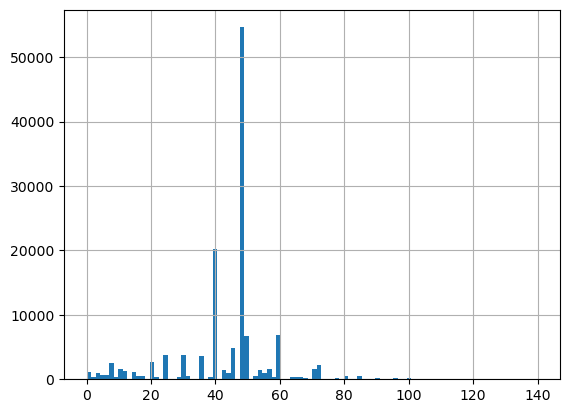

In [1467]:
personas.query("HORTRA != 'Blanco por pase'").HORTRA.hist(bins=100)

In [1470]:
(personas.query("HORTRA != 'Blanco por pase'").HORTRA <= 8).sum()

6254

In [1472]:
((personas.query("HORTRA != 'Blanco por pase'").HORTRA > 8) & (personas.query("HORTRA != 'Blanco por pase'").HORTRA <= 20)).sum()

8086

In [1474]:
((personas.query("HORTRA != 'Blanco por pase'").HORTRA > 20) & (personas.query("HORTRA != 'Blanco por pase'").HORTRA < 40)).sum()

12986

In [1485]:
pd.cut(
    personas.query("HORTRA != 'Blanco por pase'").HORTRA.astype(float),
    [0, 15, 35, 48.0001, np.inf],
    right=False
).value_counts(dropna=False)

HORTRA
[35.0, 48.0)    86245
[48.0, inf)     26344
[15.0, 35.0)    13785
[0.0, 15.0)      9546
NaN               337
Name: count, dtype: int64

In [1495]:
pd.cut(
    [48.1],
    [0, 15, 35, 48.1, np.inf],
    right=False
).value_counts(dropna=False)

[0.0, 15.0)     0
[15.0, 35.0)    0
[35.0, 48.1)    0
[48.1, inf)     1
Name: count, dtype: int64

In [1520]:
np.round(trips.query("Motivo == 'trabajo'").groupby(['HOGAR', 'HABITANTE']).stay_duration_h.sum()).value_counts()

stay_duration_h
 10.0    4246
 8.0     4090
 9.0     3552
 11.0    1614
 12.0    1476
 7.0     1141
 6.0      990
 5.0      585
 0.0      490
 4.0      417
 13.0     394
 2.0      192
 3.0      181
 14.0     177
 1.0       82
-16.0      75
-12.0      64
 15.0      57
-15.0      49
 16.0      43
-14.0      42
-13.0      23
-17.0      20
-11.0      18
 17.0      13
-10.0      12
-2.0       11
-3.0        6
-1.0        6
-18.0       5
-5.0        5
-8.0        4
 18.0       4
-7.0        4
-4.0        4
-19.0       3
-9.0        3
 19.0       1
Name: count, dtype: int64

## Imputation

Modeling options:
- Two independent model
- Sequential models
- Single model on joint categories
- Multioutput model

Independent, sequential and single joint model candidates:
- RF
- GBT
- DT

Multioutput model candidates, should output a joint probability distribution:
- RF (marginals)
- NN
- DT
- Py-boost

Outputs the joint distribution directly:
- BN

Should check if RF and NN can output a joint probability distributions, or if output are two marginal distributions.

Can the FACTORS from population synthesis be used for something?
Should imputation used them for weights?
If so, should each model be estimated by track? By municipality?
The original weights are valid at the municipality level.
Census can be reweighted by track.

It makes sense that the joint distribution of variables depends on the specific census track.
The fitted weights, thus, can inform of this change, so should be probably used.